In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['axes.facecolor']='white'

In [3]:
import utils

In [4]:
%load_ext autoreload
%autoreload 2

# 1. Lectura de datos

https://www.datosabiertos.gob.pe/dataset/casos-positivos-por-covid-19-ministerio-de-salud-minsa

In [5]:
df = pd.read_csv("positivos_covid-2.csv", delimiter=';')

In [6]:
df['FECHA_RESULTADO'] = df['FECHA_RESULTADO'].astype('Int64').astype(str).apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])

In [7]:
data = df['FECHA_RESULTADO'].value_counts().reset_index()
data.columns=['fecha', 'confirmados']
data['confirmados'] = data['confirmados'].fillna(0)
data = data.sort_values(by='fecha').reset_index(drop=True)
data['fecha'] = pd.to_datetime(data['fecha'], errors='coerce')
data = data.dropna()
data.index = data['fecha']
data.drop(columns='fecha', inplace=True)

In [8]:
#data.to_csv('covid_confirmed_peru.csv', index=True)

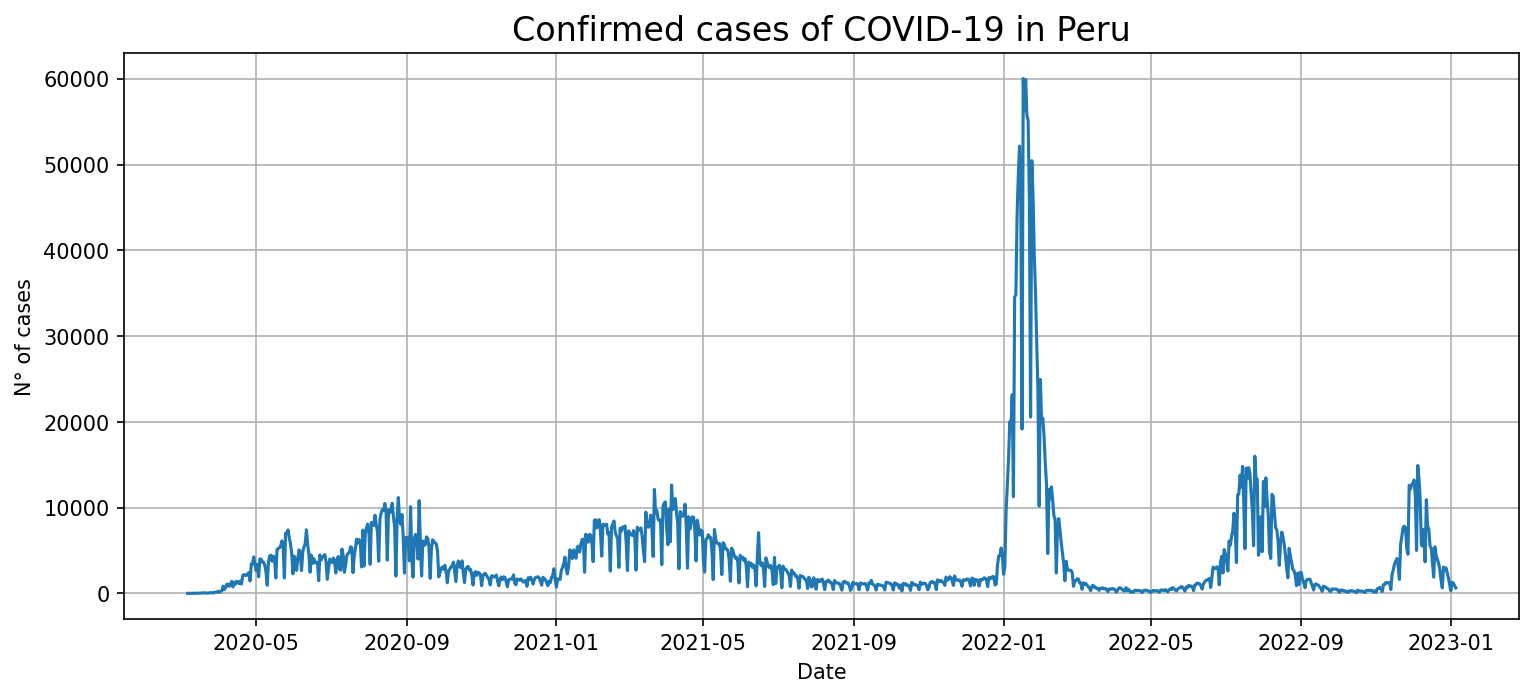

In [9]:
plt.figure(figsize=(12,5), dpi=150)
plt.plot(data.index, data['confirmados'])
plt.title('Confirmed cases of COVID-19 in Peru', fontsize=16)
plt.ylabel('N° of cases')
plt.xlabel('Date')
plt.grid()
plt.show()

# 2. Preprocesamiento

In [129]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [130]:
SPLIT_DATE = '2022-05'
df_train, df_test = data[data.index<SPLIT_DATE], data[data.index>=SPLIT_DATE]

In [131]:
#scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1,1))
scaler = RobustScaler()

scaler.fit(df_train)
train_data = scaler.transform(df_train)
test_data = scaler.transform(df_test)

In [133]:
scaled_data = np.concatenate([train_data, test_data],axis=0)

In [134]:
LOOKBACK_DAYS = 30
FORECAST_WINDOW = 1

X, y = utils.generate_sequences(scaled_data, LOOKBACK_DAYS, FORECAST_WINDOW)

In [135]:
test_size = test_data.shape[0]
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [136]:
X_train.shape, X_test.shape

((754, 30, 1), (250, 30, 1))

# 3. Dataloaders

In [137]:
import torch
from torch.utils.data import DataLoader

In [138]:
train_dataset = utils.SequenceDataset(X_train, y_train)
test_dataset = utils.SequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 4. Modeling

In [139]:
import pytorch_lightning as pl

In [202]:
torch.manual_seed(9)

model = utils.LSTMRegressor(1, 24, 1, 4)

trainer = pl.Trainer(max_epochs=100,
                     callbacks=[pl.callbacks.EarlyStopping(monitor="val_loss", mode="min")])

trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params
-----------------------------------
0 | rnn     | LSTM   | 17.0 K
1 | hidden  | Linear | 600   
2 | out_lin | Linear | 25    
-----------------------------------
17.6 K    Trainable params
0         Non-trainable params
17.6 K    Total params
0.070     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/leo/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/leo/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/leo/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (48) is smaller than the logging interval Traine

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# 5. Evaluation

In [203]:
model.eval();

In [204]:
train_loader2 = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader2 = DataLoader(test_dataset, batch_size=16, shuffle=False)

## 5.1 Single window predictions

In [205]:
train_predictions = []
test_predictions = []

with torch.no_grad():
    for batch_X, _ in train_loader2:
        train_predictions.append(model(batch_X))

    for batch_X, _ in test_loader2:
        test_predictions.append(model(batch_X))

    train_predictions = torch.cat(train_predictions, dim=0).numpy()
    train_predictions = scaler.inverse_transform(train_predictions).reshape(-1,)

    test_predictions = torch.cat(test_predictions, dim=0).numpy()
    test_predictions = scaler.inverse_transform(test_predictions).reshape(-1,)

train_pred = pd.Series(train_predictions, index = df_train.index[LOOKBACK_DAYS:])
test_pred = pd.Series(test_predictions, index = df_test.index)

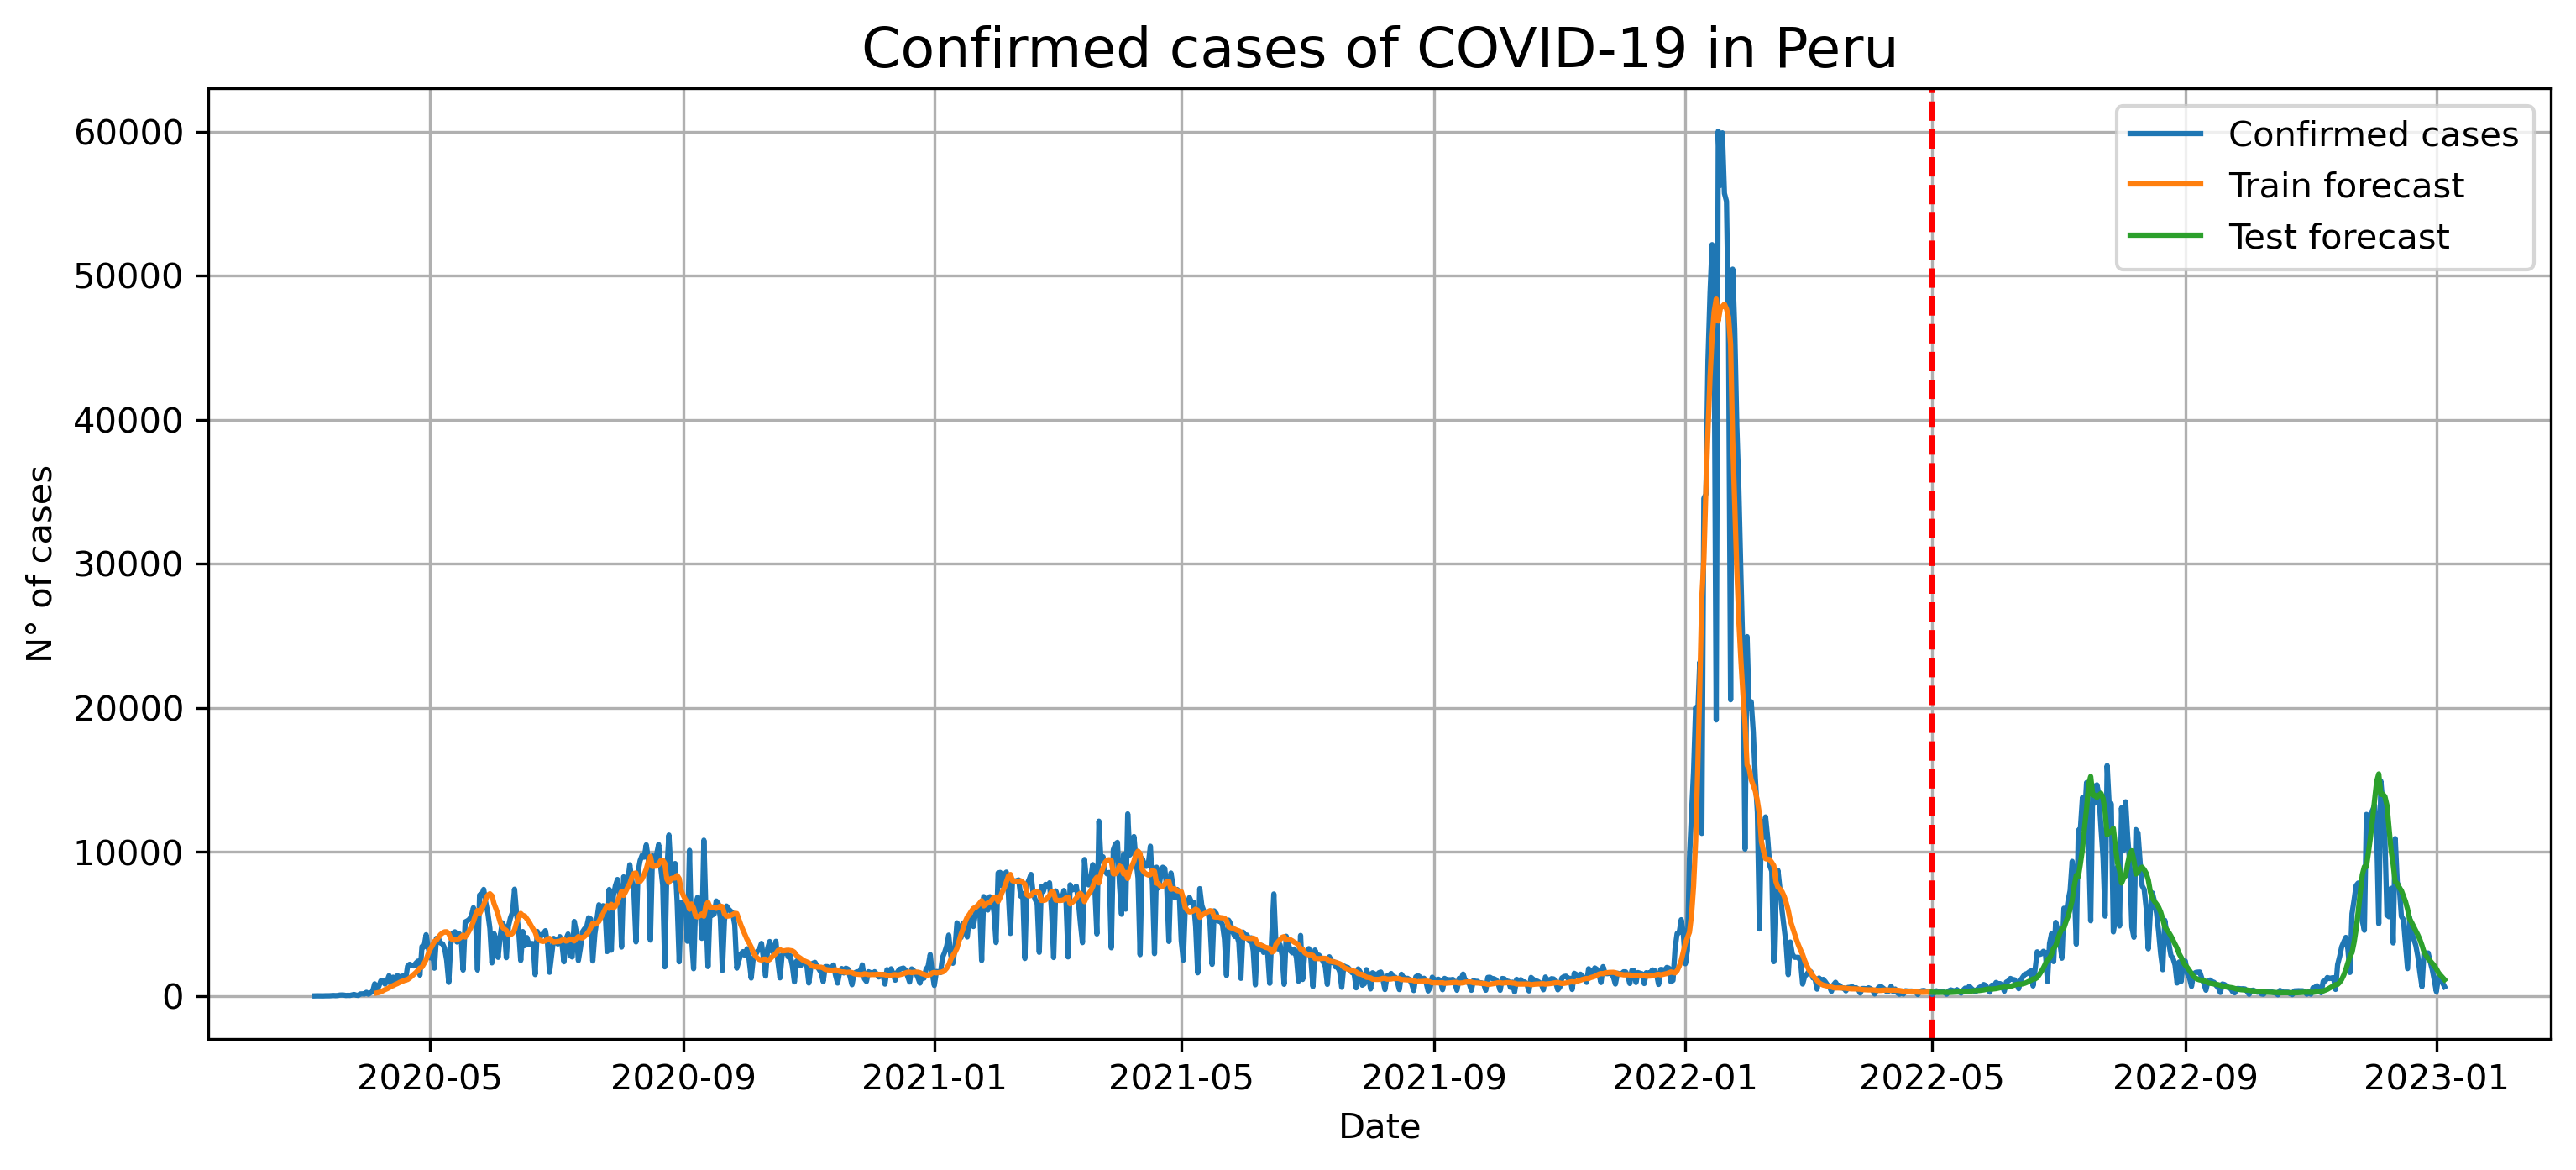

In [237]:
fig = plt.figure(figsize=(12,5), dpi=300)
fig.set_facecolor("white")

plt.axvline(pd.Timestamp(SPLIT_DATE), c='r', linestyle='--')

plt.plot(data.index, data['confirmados'], label='Confirmed cases')
plt.plot(train_pred.index, train_pred, label='Train forecast')
plt.plot(test_pred.index, test_pred, label='Test forecast')

plt.title('Confirmed cases of COVID-19 in Peru', fontsize=16)
plt.ylabel('N° of cases')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.show()

## 5.2 Autoregressive predictions (next 30 days)

In [222]:
AR_FORECAST_WINDOW = 60

In [223]:
current_batch = scaled_data[-LOOKBACK_DAYS:]
current_batch = current_batch.reshape(1, LOOKBACK_DAYS, 1)
current_batch = torch.tensor(current_batch).float()


true_test_predictions = []
forecast_window = AR_FORECAST_WINDOW


with torch.no_grad():
    
    for i in range(forecast_window):
        current_pred = model(current_batch)
        true_test_predictions.append(current_pred.item())
        current_batch = torch.cat([current_batch[:,1:,:],current_pred.unsqueeze(0)],axis=1)

true_test_predictions = np.array(true_test_predictions).reshape(-1,1)
true_test_predictions = scaler.inverse_transform(true_test_predictions).flatten()

time_series_array = df_test.index
for k in range(0, AR_FORECAST_WINDOW):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

true_test_predictions = pd.Series(true_test_predictions, index = time_series_array[-AR_FORECAST_WINDOW:])

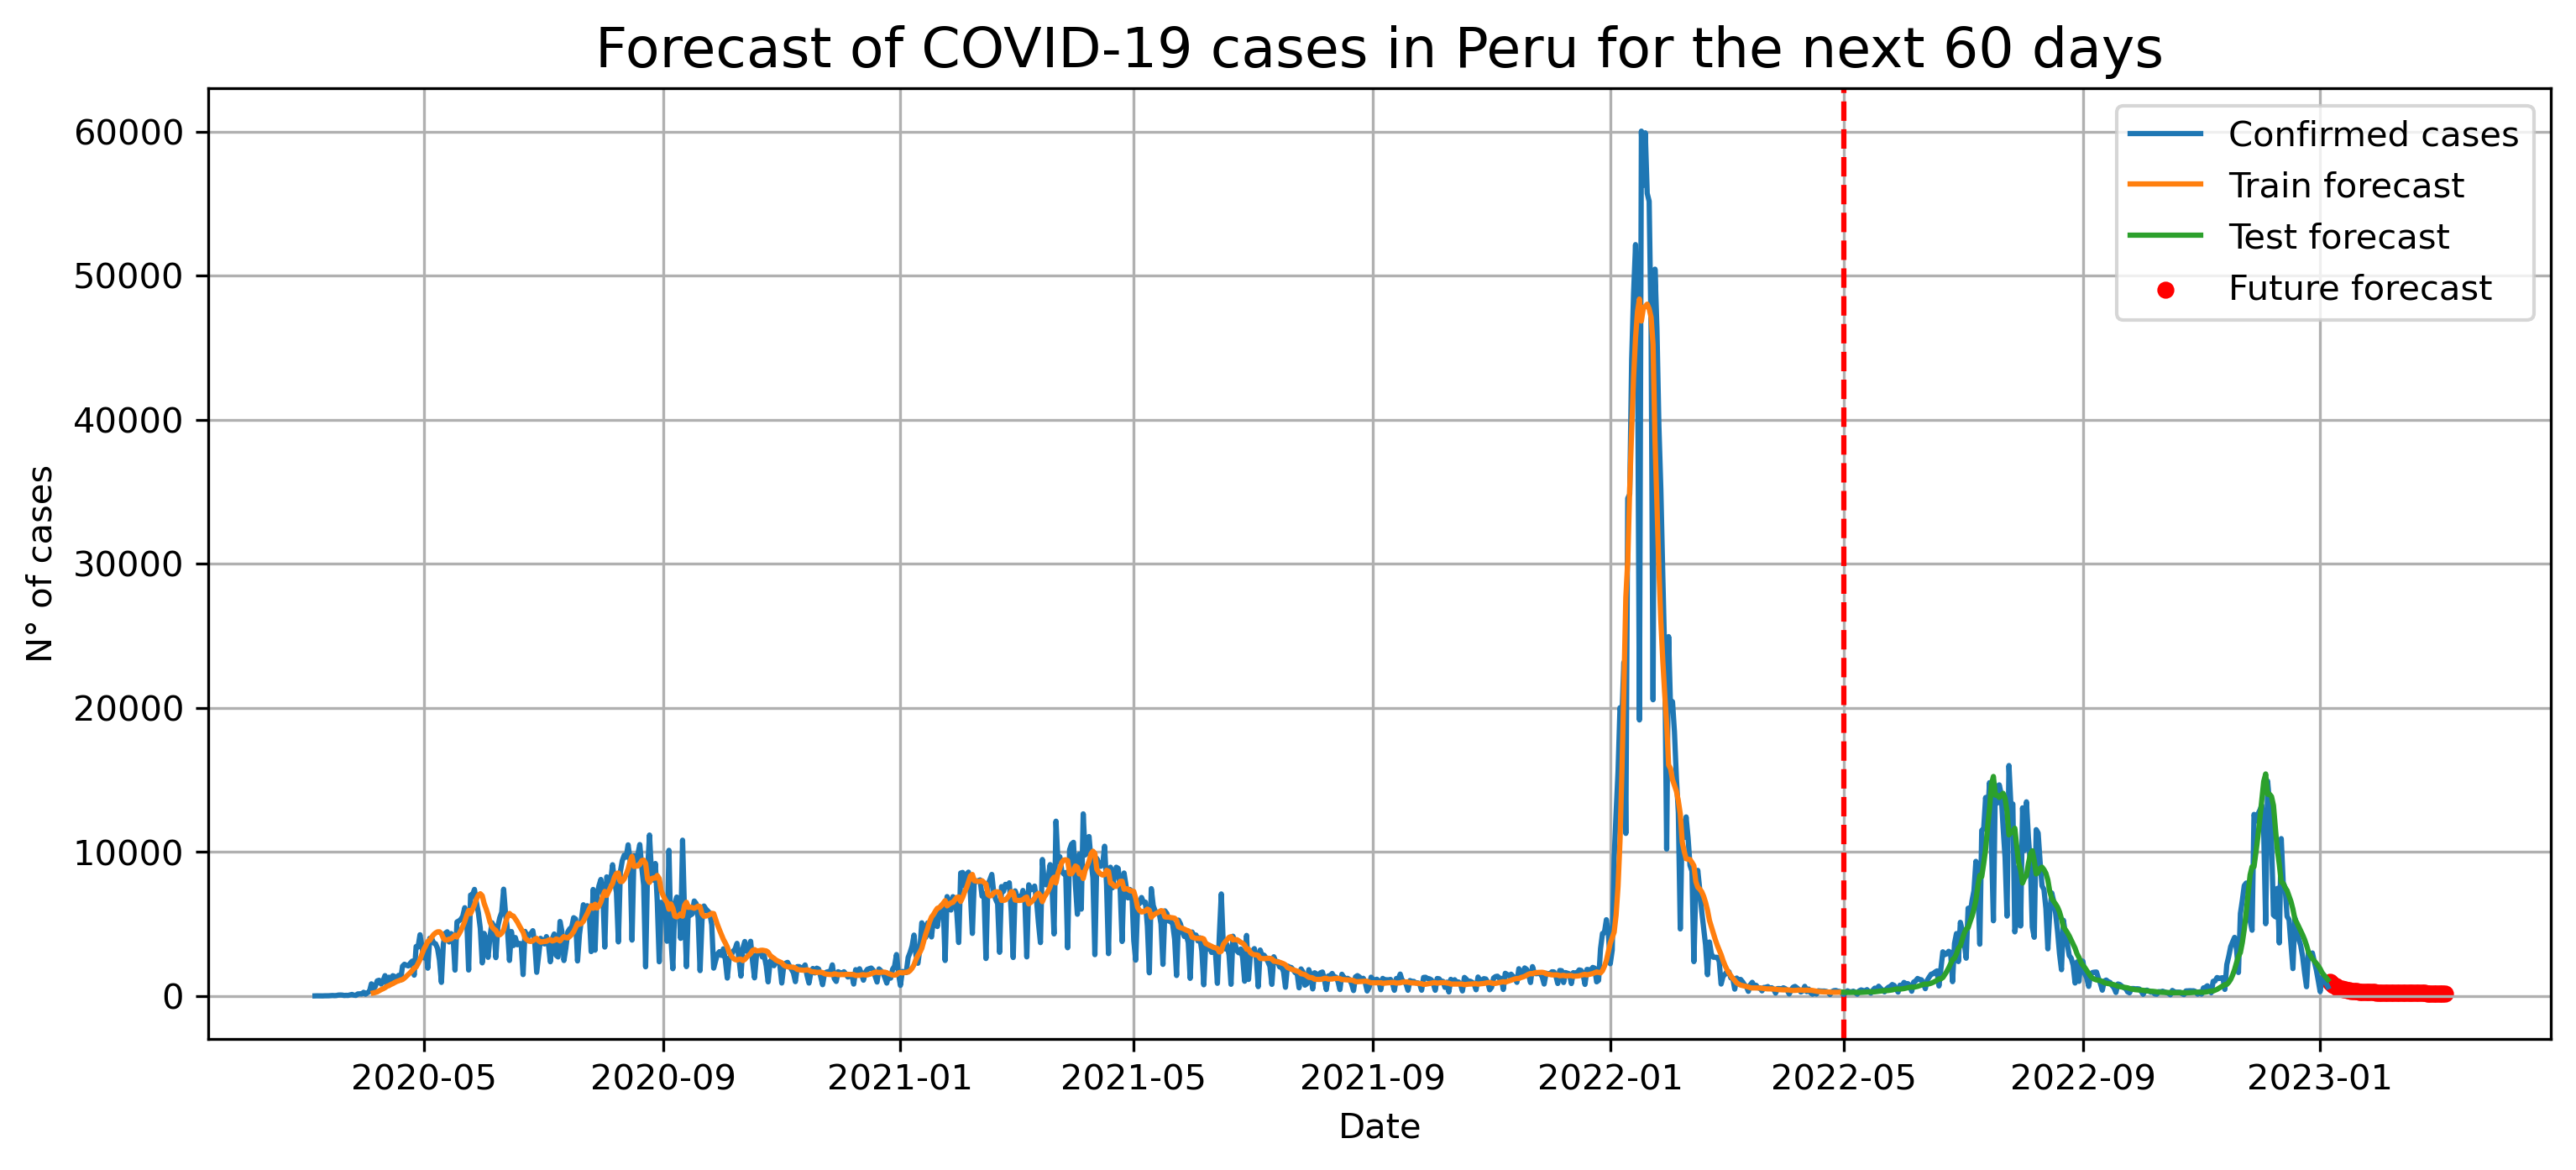

In [236]:
fig = plt.figure(figsize=(12,5), dpi=300)
fig.set_facecolor("white")


plt.axvline(pd.Timestamp(SPLIT_DATE), c='r', linestyle='--')
plt.plot(data.index, data['confirmados'], label='Confirmed cases')
plt.plot(train_pred.index, train_pred, label='Train forecast')
plt.plot(test_pred.index, test_pred, label='Test forecast')




plt.scatter(true_test_predictions.index, true_test_predictions, label='Future forecast', color='red', s=15)

plt.title(f'Forecast of COVID-19 cases in Peru for the next {AR_FORECAST_WINDOW} days', fontsize=16)
plt.ylabel('N° of cases')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.show()